In [57]:
from imports import *


# machine learning
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

pd.options.display.max_columns = 100

### Problem Statement and Research Question

Economic growth is traditionally understood to be driven by three fundamental factors: human capital, geography, and institutions. These drivers shape the trajectory of nations and are frequently studied in growth literature. Less explored, however, are the reasons why these three factors vary across countries. We hypothesize that people’s beliefs play a key role in economic development. Specifically, we argue that beliefs about trust, equality, work ethic, and religion influence the likelihood of countries to adopt democratic institutions. Value formation, after all, likely shapes citizens’ willingness to accept democracy. We expect to find that the aforementioned values are strongest in countries with democratic traditions and weakest in countries with autocratic traditions.

As such, our main research question is:

“What is the relationship between the moral values of a country — regarding trust, work ethic, religion, and equality — and the adoption of democratic institutions? What is the relative importance of each of these beliefs to constructing a working democracy?”


We use the World Values Survey (WVS), a dataset which provides survey data on peoples' beliefs, attitudes, and values across a large number of countries from 1995 to 2024, to start answering this question. We use this data to quantify the values of each country along the axes of trust, work ethic, religion, and equality over time. With this panel dataset, we then have the ability to explore the association between a country's values and their democracy index score (a score published by The Economist detailing how democratic a country is). We engage in this analysis below:

### Exploring and Visualizing Data

In [58]:
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")

# 1. Initial Data Cleaning

We used four datasets for this project: the World Values Survey (WVS), the Economist's Democracy Index (as a response variable), the UN's GDP per capita time series, and the UN's Human Development Index (HDI). 

The WVS data set has longitudinal data from seven waves of cross-sectional surveys about citizens' values. Because Democracy Index has only been measured since 2006, we had to limit our analysis of the WVS data to the three most recent waves: wave 5 (2005-2009), wave 6 (2010-2014), and wave 7 (2017-2022). 

The dataset is structured as follows: Our predictors (i.e. each belief value for a country) are gained by collapsing all survey observations within a given country-wave combination (with weights provided by the WVS). Now, given the country-wave dataset that we have where we also have the weighted average response values to each of the survey questions we chose for each value category (see Appendix for specific questions), we can then get our value score by taking the average of our constituent categories. For example, for work ethic, we would be taking the average of questions A005, E040, A030, A104 for a given country-wave observation to get the work ethic score for that observation. If one of the questions in a category are missing, we just use the other questions available and equal-weight them (though this is an issue we rarely ran into, and if it did occur, it was constant for all countries within a wave meaning our results should not be biased). This method ensures that all of our countries, regardless of their population size, are equally represented (we discuss more about this in our data imbalance section).

After cleaning the individual datasets, we merged the control variables (HDI and GDP), the dependent variable (Democracy Index), and the predictors (four categories from the WVS). 

**Data Imbalance / Missingness **
Not all countries are surveyed across all three waves in which we are interested. For example, Argentina might appear in wave 6, but not wave 5 or wave 7, whereas France might appear in all three waves. This is an issue because it means that the countries that are surveyed in all three waves are effectively overrepresented in the sample, imbalancing our data.

To deal with this, we cannot just subset to look at countries present in all three waves; that would remove too much data that could provide valuable insight. Instead, we will increase the weight given to countries that are underrepresented. For example, in the above scenario, Argentina’s wave 6 observation would be given thrice the weight as France. In practice, this means duplicating/resampling country observations until each country has 3 observations. This is a reasonable solution, because we want to ensure that the relationship between our moral values indices — constructed from WVS responses — and the Democracy Index equally contributes to the model. 

Moreover, we have that some of the questions themselves have missing responses when we are at the person-level of the survey (before we weighted average collapse by country-wave). The WVS organizers categorize these missing responses into the following categories: “Don’t Know,” “No Answer,” “Not Applicable,” “Missing/Unknown,” and “Not Asked.” The final category is dealt with by just leaving the value as missing (as all members of a given wave are not asked this question). We deal with the other four categories using hot deck imputation, where we pick a random non-missing observation within the same country-wave combination to serve as our donor for the data. Imputation is reasonable as long as the data is MAR and MCAR, and not MNAR. For most cases, this assumption seems plausible, as it is difficult to imagine any structural characteristics of an individual that are correlated with, say, a “No Answer” response, especially given that the survey is anonymous. Our cleaning_wvs_raw.ipynb file submitted with this notebook goes into this process in more detail with more associated graphs and changes.

However, even if the imputation does introduce some degree of bias, it is likely quite small, because only a very small percentage of the survey is actually missing in the first place (see our cleaning_wvs_raw.ipynb file). 

When years were missing in the Democracy Index, we averaged the indices during the preceding and subsequent years, which is reasonable given that Democracy Index does not fluctuate much on a yearly basis. 

Due to a lack of GDP/HDI data for certain countries in the WVS (Macau, N. Ireland), we simply dropped these countries. 

**Scaling (not Standardization)**
Unfortunately, the WVS's values for each question are on different scales. For some questions, a 1 indicates higher belief in a certain value while for others a 10 does. Moreover, we have that the scales of questions are different: some only move from 1 to 2 and others go from 1 to 10. Thus, we reordered the scales in the correct direction where a higher value indicates a greater belief in the given value and then will normalize our data to be on a scale of 0-5 for each question. The specifics of these changes are in our cleaning_Wvs_raw.ipynb file.

**Note** Two files are attached. The first, “cleaning_wvs_raw.ipynb” analyzes our missing data and talks
about imputation. The second, “controls_cleaning.ipnyb” cleans our controls data and discusses missing
countries.

Below is our dataframe head is a **summary table**. The sample includes 89 countries over 3 time periods. GDP per capita is in constant 2010 US dollars. The Democracy Index ranges from 0 (least democratic) to 10 (most democratic). The Human Development Index ranges from 0 (least developed) to 1 (most developed). Work ethic, trust, equality and religion are standardized indices ranging from 0-5. 

In [59]:
df.head()

,Country,Year,democracy_score,work_ethic,trust,equality,religion,country,gdp_per_capita,gdp_per_capita_std,gender_beat_wife,gender_business_exec,gender_job_rights,gender_political_leaders,gender_rights,hdi,religion_against_science,religion_attendance,religion_child,religion_confidence,religion_god,religion_god_importance,religion_identification,religion_only_religion,religion_pray,religion_right,tolerance_chairty_confidence,tolerance_charitable_org,tolerance_human_rights,tolerance_immigrant_work,tolerance_immigrants,tolerance_other_race,trust_first_meet,trust_most_people,trust_neighborhood,trust_other_national,trust_other_religion,trust_personally,work_child,work_importance,work_membership_pro_org,work_success,wave
0,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0
1,Argentina,2013,6.84,2.056866,2.421878,3.357302,2.710240,ARG,13080.254732,-0.076785,4.744030,3.402337,3.827324,3.145191,4.248363,0.846,3.072915,2.041670,1.161009,2.559173,4.669794,3.607358,4.166942,1.413569,2.592646,1.817325,2.797419,0.529656,2.441110,1.983986,4.860343,4.950563,1.765118,0.992374,3.154370,2.579455,2.605160,3.434793,2.032350,4.032228,0.334831,1.828054,2.0
2,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0
3,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0
4,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0


In [60]:
# Create numeric summary statistics
summary = pd.DataFrame()

numeric_vars = ['democracy_score', 'work_ethic', 'trust', 
               'equality', 'religion', 'gdp_per_capita', 'hdi']

for var in numeric_vars:
    stats = pd.Series({
        'Count': df[var].count().round(0),
        'Mean': df[var].mean().round(2),
        'Std Dev': df[var].std().round(2),
        'Min': df[var].min().round(2),
        '25%': df[var].quantile(0.25).round(2),
        'Median': df[var].median().round(2),
        '75%': df[var].quantile(0.75).round(2),
        'Max': df[var].max(),
        'Missing': df[var].isna().sum(),
        'Missing %': (df[var].isna().sum() / len(df[var])) * 100
    }).round(3)
    
    summary[var] = stats
    
# Print categorical summary
print("\nDataset Overview:")
print("-----------------")
print(f"Number of Columns: {df.shape[1]}")
print(f"Number of Countries: {len(df['country'].unique())}")
print(f"Number of Periods: 3")
print(f"Total Observations: {df.shape[0]}")

# Display the styled table
display(summary)


Dataset Overview:
-----------------
Number of Columns: 43
Number of Countries: 89
Number of Periods: 3
Total Observations: 267


,democracy_score,work_ethic,trust,equality,religion,gdp_per_capita,hdi
Count,267.00,267.000,267.000,267.000,267.000,267.000,267.000
Mean,5.85,2.370,2.220,2.860,3.060,15878.290,0.750
Std Dev,2.11,0.340,0.470,0.440,0.800,19524.020,0.140
Min,1.74,1.580,0.530,1.400,1.080,240.350,0.340
25%,3.97,2.130,1.930,2.610,2.440,2189.810,0.660
Median,5.98,2.340,2.170,2.770,3.250,6475.720,0.760
75%,7.56,2.600,2.440,3.070,3.750,21279.460,0.860
Max,9.88,3.895,3.541,3.975,4.346,85502.268,0.949
Missing,0.00,0.000,0.000,0.000,0.000,0.000,0.000
Missing %,0.00,0.000,0.000,0.000,0.000,0.000,0.000


## 2. Histograms

The below figure displays the histogram of each feature for each different wave of data. 

The democracy scores appear to be the feature with the most variance (we also see this by our std dev value for this variable in our earlier summary table). Indeed, whereas the six predictors tend to cluster within only a part of the distribution (with the exception of religion and sometimes HDI), the democracy scores is close to occupying nearly the entire range between 1 and 10. 

The religion distribution appears to have a slight shift leftward over time, whereas the trust distribution appears to have a slight shift rightward (the data is no longer skewed left by wave 3). Obviously, these are weak conclusions as the religion histogram still has observations across all values by wave 3 and trust also still has some observations at the lower end by wave 3. Regardless, these changes across waves in the distribution can indicate that using wave-fixed effects in a regression model would be useful to only capture the impact of factors that vary across waves and not within waves.

GDP is right-skewed, HDI is somewhat left-skewed (though not very strongly, especially for earlier waves!), and the democracy score value does not appear to have a clear distribution. The scores for some of the moral values such as equality and trust (especially in wave 3) appear to be reasonably normally distributed, but again, there is no strong normality in these predictors. In addition, GDP is the only variable with significant outliers. Since the GDP is right skewed, it likely warrants a log transformation. 

As a caveat, these histograms are part of our EDA and any of the ideas we are drawing from these histograms are not full conclusions, but rather observations that we think will be helpful to informing our baseline model.

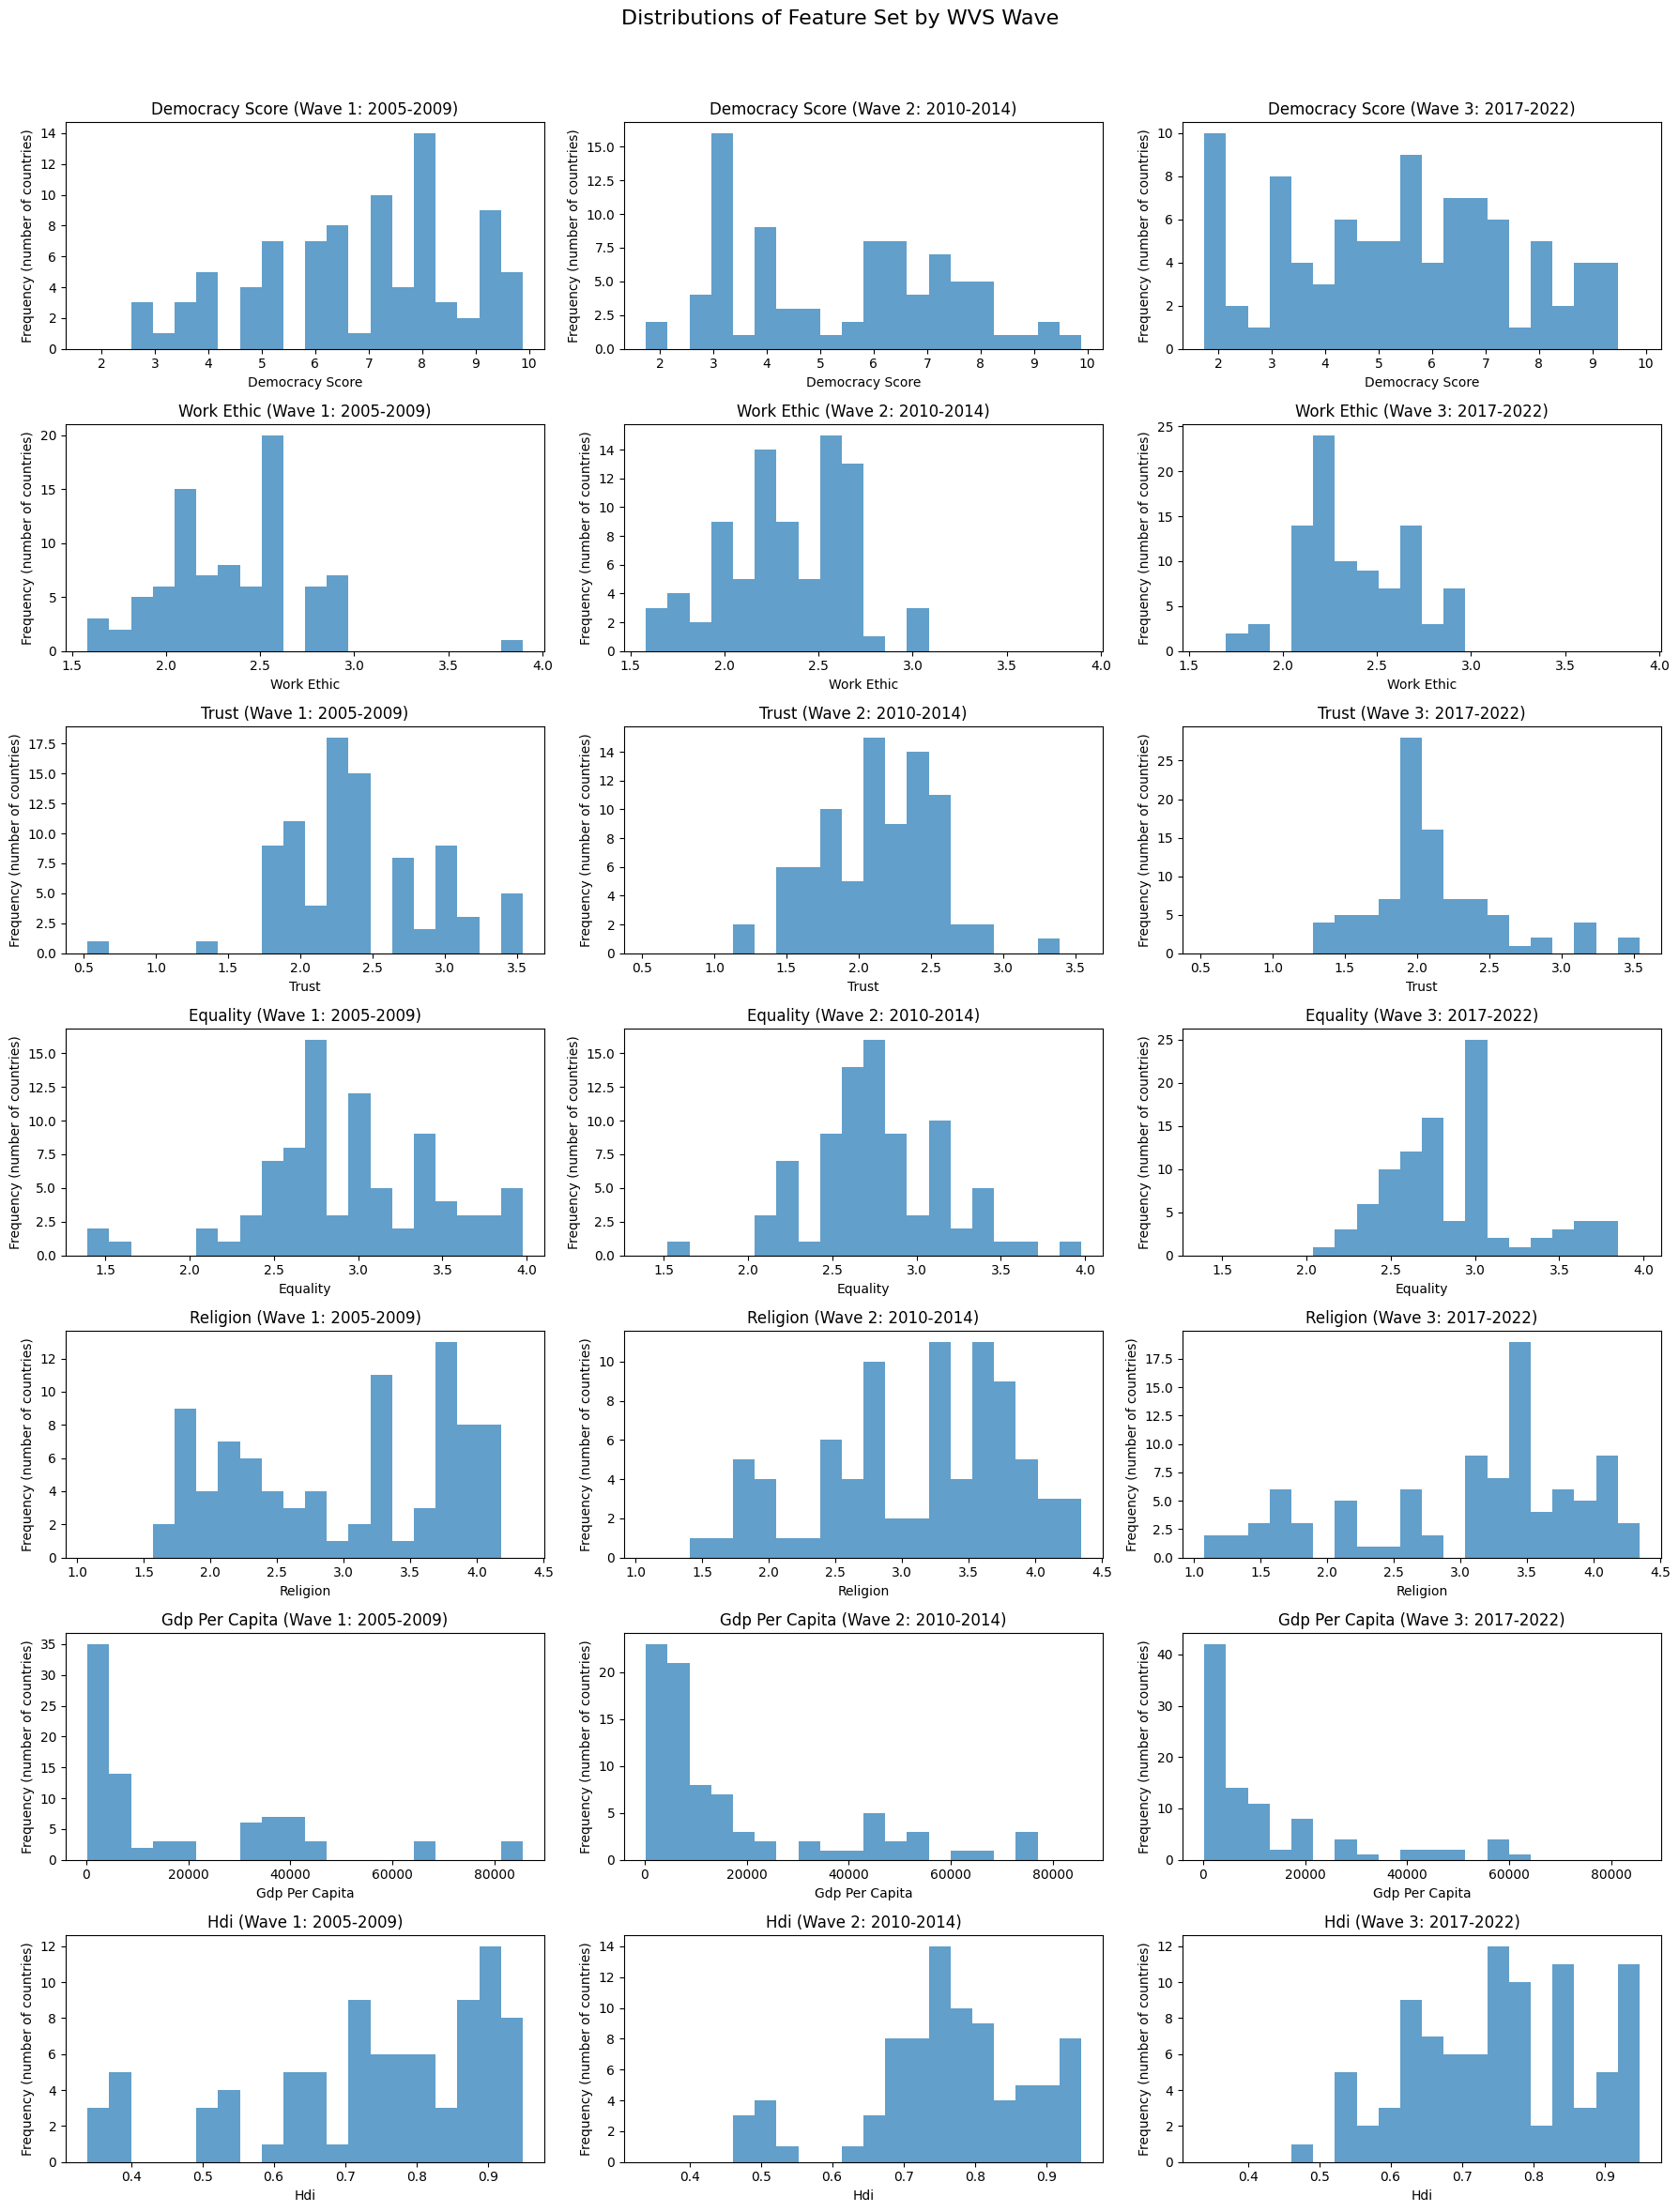

In [61]:
# create figure
fig, axes = plt.subplots(7, 3, figsize=(18, 24))
fig.suptitle('Distributions of Feature Set by WVS Wave', fontsize=16)

# I am add to waves so that they cover all of time from 1995.
# Assumption, associate data back one wave if is not in a wave. 
moral_values = ["democracy_score", "work_ethic", "trust", "equality", "religion", "gdp_per_capita", "hdi"]
waves = {1: [2005, 2009], 2: [2010, 2014], 3: [2017, 2022]}

# Create histograms for each combination
for i, value in enumerate(moral_values):
    # Get range for current moral value for consistent binning
    value_range = (df[value].min(), df[value].max())
    
    for j, (wave, years) in enumerate(waves.items()):
        # Filter data for current wave
        wave_data = df[(df['Year'] >= years[0]) & (df['Year'] <= years[1])]
        
        # Create histogram
        axes[i, j].hist(wave_data[value], bins=20, alpha=0.7, range=value_range)
        
        # Fix labeling
        value_name = value.replace('_', ' ').title()
        axes[i, j].set_title(f'{value_name} (Wave {wave}: {years[0]}-{years[1]})')
        axes[i, j].set_xlabel(value_name)
        axes[i, j].set_ylabel('Frequency (number of countries)')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/histograms.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Violin Plots and Scatter Plots 
### Violin Plots
The following violinplots show the distribution of each score --- trust, work ethic, equality, and religion --- when cut into income, human development index, and democracy index, quartiles. This plot yields several interesting conclusions:

1) Across all cuts, there appears to be a pretty general trend in mean score, either upward or downward. In other words, the mean score typically trends upward or downward over the quartiles we present. This suggests that the scores are quite correlated with income, human development, and democracy.

2) Most scores increase, on average, as income, HDI, and democracy increase. But work ethic and religion seem to _decrease_! This is very interesting and poses new questions about the relation between work ethic, religion, and democracy. It appears that wealthier countries and thus more democratic countries are less religious. This could make sense as we think of many religious states that are frequently undemocratic. The work ethic argument is harder to directly understand. Our prior was that a democratic country where there is a better institution of equality of opportunity would be correlated with more people valuing work ethic (the idea of pulling yourself up by your bootstraps). We will explore these relationships further in our baseline.

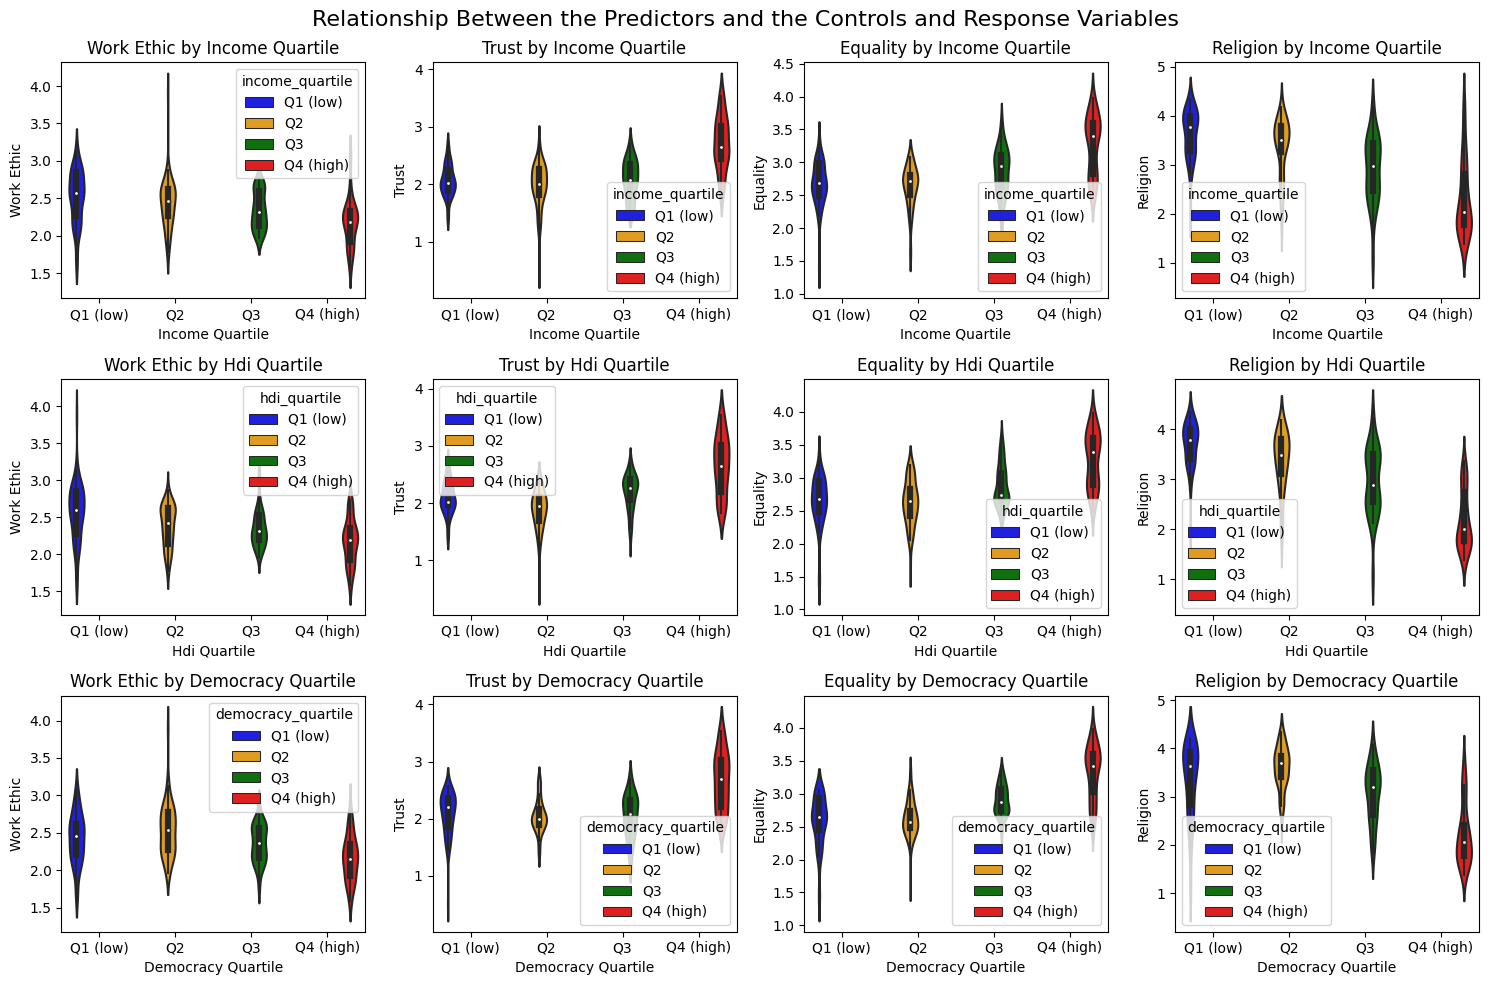

In [62]:
# create income quartiles
df['income_quartile'] = pd.qcut(df['gdp_per_capita'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create HDI buckets
df['hdi_quartile'] = pd.qcut(df['hdi'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create Democracy buckets
df['democracy_quartile'] = pd.qcut(df['democracy_score'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create violinplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Relationship Between the Predictors and the Controls and Response Variables', fontsize=16)

cuts = ["income_quartile", "hdi_quartile", "democracy_quartile"]
scores = ["work_ethic", "trust", "equality", "religion"]

for i, cut in enumerate(cuts):
    for j, predictor in enumerate(scores):
        sns.violinplot(data=df, x=cut, y=predictor, ax=axes[i, j], hue = cut, palette = ["blue", "orange", "green", "red"])
        
        # fix labelling
        x_name = cut.replace('_', ' ').title() 
        y_name = predictor.replace('_', ' ').title()
        axes[i, j].set_title(f"{y_name} by {x_name}")
        axes[i, j].set_xlabel(f"{x_name}")
        axes[i, j].set_ylabel(f"{y_name}")

plt.tight_layout()
plt.savefig('figures/violinplots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Scatterplots
Below are the scatterplots of the predictor variables on the dependent variable.
1) From a first pass, the relationships between GDP and Democracy and HDI and Democracy do not appear linear, they look logarithmic. GDP and HDI also seem to have a strong positive relationship with democracy. This does not tell us that we are controlling for all important possible control variables, but does make the clear the importance of controlling for HDI and GDP. We will transform GDP to account for the nonlinearity before using it in our OLS model. 
2) Most relationships are generally positive, except religion and work ethic, which are negative.
3) We see that the religion and trust variables have the closest to a non-linear (logarithmic in this case) relationship with democracy index. We will run our OLS baseline model and examine the assumptions of the regression (linearity of residuals, homoskedaskcity) to determine whether linearity was a reasonable assumption or whether transformations should be done.

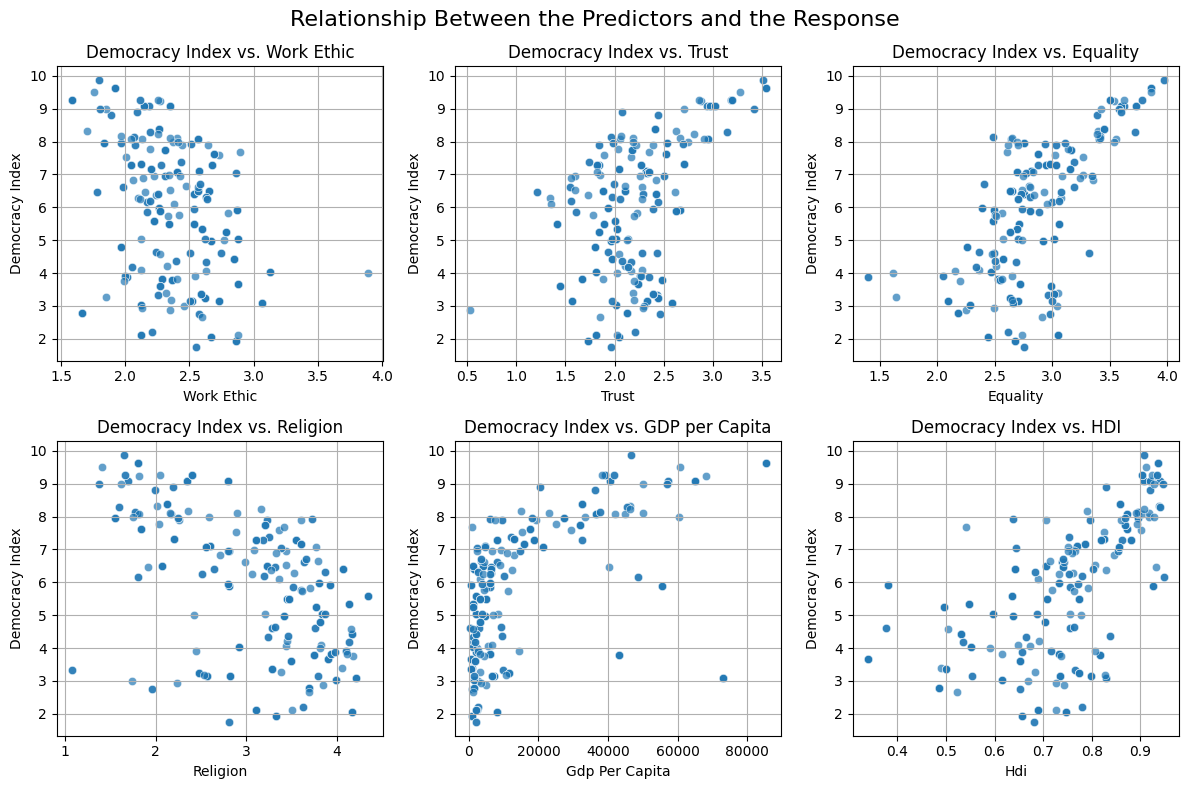

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Relationship Between the Predictors and the Response', fontsize=16)

ax = ax.ravel() 

x_vars = ['work_ethic', 'trust', 'equality', 'religion' , 'gdp_per_capita', 'hdi']
titles = ['Democracy Index vs. Work Ethic', 
          'Democracy Index vs. Trust', 
          'Democracy Index vs. Equality', 
          'Democracy Index vs. Religion', 
          'Democracy Index vs. GDP per Capita', 
          'Democracy Index vs. HDI']

for i, (x_var, title) in enumerate(zip(x_vars, titles)):
    sns.scatterplot(x=x_var, y='democracy_score', data=df, alpha=0.7, ax=ax[i])
    ax[i].set_title(title)
    ax[i].set_xlabel(x_var.replace('_', ' ').title()) 
    ax[i].set_ylabel('Democracy Index')
    ax[i].grid()

plt.tight_layout()
plt.savefig('figures/scatterplots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Correlation Heatmap

Here is a heatmap showing the correlation amongst all the features. 
The highest correlations are among democracy, hdi, and gdp per capita. Religion has a negative correlation with every other predictor other than work ethic and the same for work ethic. All other variable have postive correlations with each other. The significant correlation between our predictors, our control variables, and our response variable suggest significant multicollinearity in our dataset.

1) Religion and work ethic are the only predictor that is negatively correlated with any other predictor (other than each other).

2) The most highly correlated variables are the democracy index, GDP per capita, and HDI. All three are also positively correlated with most of the moral value scores. This means that GDP per capita and HDI are two significant confounders — they are correlated both with our predictors of interest and with the outcome.

These correlations hint at the possible problem of multicolinearity. However, even if present, this is not a severe issue due to the magnitude of the coefficients of correlation we see above: for all the predictors we care about, |r| < 0.7.

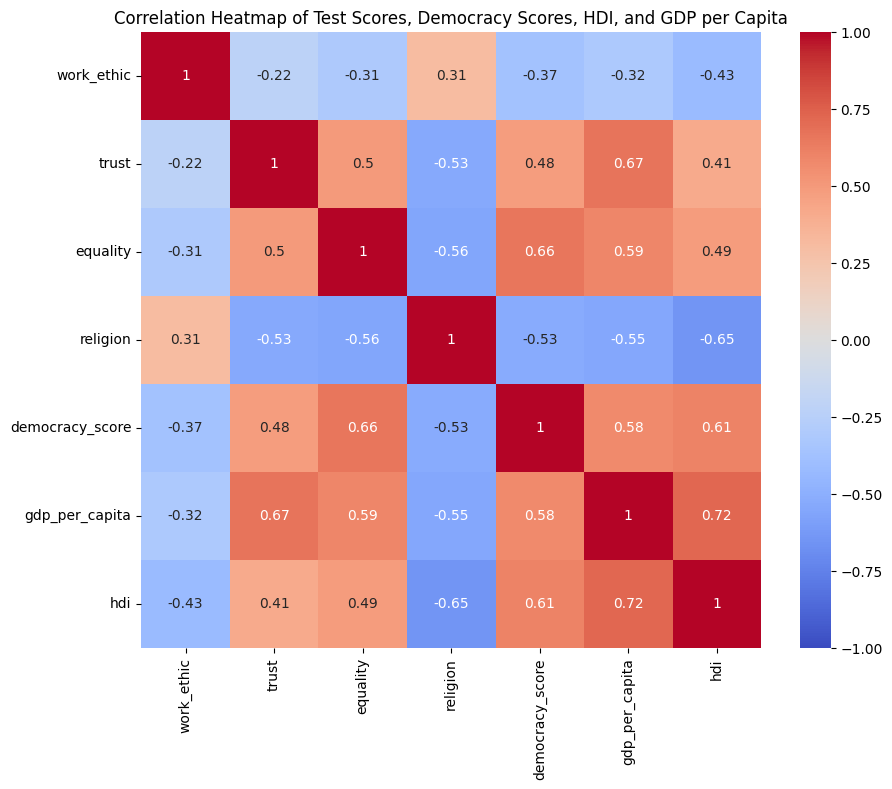

In [64]:
# Select the relevant columns for correlation
correlation_data = df[['work_ethic', 'trust', 'equality', 'religion', 'democracy_score', 'gdp_per_capita', 'hdi']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Test Scores, Democracy Scores, HDI, and GDP per Capita')
plt.savefig('figures/corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Discussion on confounders

Finally, we will discuss potential confounders in our dataset. First, we have already controlled for GDP per capita and HDI, which are clear confounding variables. Other unobserved confounding variables include other historical and institutional factors, like whether or not a country has had colonial history or what the educational system’s characteristics are, even beyond HDI. We can try to operationalize the fact that we have panel data and deploy country and wave fixed effects to control for these unobserved confounders to figure out the true effect of the moral values on democracy. However, since we have pretty limited time series data within countries, wave fixed effects will likely be all we are able to implement as adding country fixed effects will lead to significant overfitting.


### Baseline Model and Results Interpretation

Based on our EDA, we believe that beginning with a multiple OLS regression and a LASSO regression as our baseline models is optimal. This is for a few reasons:

1. The relationships between our predictors and our response variable are reasonably linear (with the exception of GDP per capita which we will log transform). This means that a linear regression and its ensuing inference is likely to be valid. Of course, we saw some nonlinearities in our EDA, but these nonlinearities do not warrant a different model, in our opinions.

2. An OLS linear regression and a LASSO regression are both simple, interpretable ways of understanding the associations between our values and the democracy index and also provide separate, easily interpretable forms of feature selection. Starting our modeling with interpretable methods will be useful to us when we think about how we want to move forward with modeling!

3. The OLS linear regression gives us the chance to perform statistical inference which is useful as we are trying to understand what values are closely associated with democracy across different countries. 

4. The LASSO regression gives us another way to check on the features selected by our OLS regression while still preserving interpretability. 

In [65]:
# get our dataframe and create log gdp per capita plus equality squared (for later use)
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")
df["log_gdp_per_capita"] = np.log(df["gdp_per_capita"])
df['equality_squared'] = df['equality']**2

In [66]:
df

,Country,Year,democracy_score,work_ethic,trust,equality,religion,country,gdp_per_capita,gdp_per_capita_std,gender_beat_wife,gender_business_exec,gender_job_rights,gender_political_leaders,gender_rights,hdi,religion_against_science,religion_attendance,religion_child,religion_confidence,religion_god,religion_god_importance,religion_identification,religion_only_religion,religion_pray,religion_right,tolerance_chairty_confidence,tolerance_charitable_org,tolerance_human_rights,tolerance_immigrant_work,tolerance_immigrants,tolerance_other_race,trust_first_meet,trust_most_people,trust_neighborhood,trust_other_national,trust_other_religion,trust_personally,work_child,work_importance,work_membership_pro_org,work_success,wave,log_gdp_per_capita,equality_squared
0,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0,9.589669,11.220353
1,Argentina,2013,6.84,2.056866,2.421878,3.357302,2.710240,ARG,13080.254732,-0.076785,4.744030,3.402337,3.827324,3.145191,4.248363,0.846,3.072915,2.041670,1.161009,2.559173,4.669794,3.607358,4.166942,1.413569,2.592646,1.817325,2.797419,0.529656,2.441110,1.983986,4.860343,4.950563,1.765118,0.992374,3.154370,2.579455,2.605160,3.434793,2.032350,4.032228,0.334831,1.828054,2.0,9.478859,11.271477
2,Argentina,2017,6.96,2.308943,2.496937,3.349680,2.805873,ARG,14613.035649,-0.002063,4.713936,3.605759,3.879697,3.488592,4.287758,0.853,3.067606,2.024237,1.197550,2.760491,4.666443,3.575449,4.222373,1.703456,2.679850,2.161279,3.014905,0.318971,2.464931,1.415137,4.793826,4.862961,1.895876,1.016820,3.336227,2.635871,2.728511,3.368316,2.823198,4.181511,0.204718,2.026343,3.0,9.589669,11.220353
3,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0,8.511735,7.353462
4,Armenia,2021,5.49,2.536477,1.888417,2.711727,3.447211,ARM,4972.783204,-0.472020,4.820998,2.601450,2.059424,2.311143,4.272454,0.774,3.561399,1.892354,1.671786,3.462924,4.733399,4.519103,4.525404,3.916994,3.426459,2.762293,2.510905,0.447444,1.990692,1.038217,4.176748,3.599520,1.424604,0.425027,2.997472,1.769796,1.383922,3.329680,3.556984,4.468816,0.435577,1.684531,3.0,8.511735,7.353462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,Zambia,2007,5.25,2.786944,1.839630,2.635808,3.764925,ZMB,1133.436158,-0.659186,3.133333,2.537778,2.955000,2.428889,3.865000,0.495,2.481481,3.773810,3.046667,4.017778,NaN,4.544815,4.725000,NaN,NaN,NaN,2.630000,0.876667,2.548889,0.868333,3.623333,3.526667,1.256667,0.560000,2.766667,1.567778,2.100000,2.786667,4.056667,4.516667,1.083333,1.491111,1.0,7.033009,6.947484
263,Zambia,2007,5.25,2.786944,1.839630,2.635808,3.764925,ZMB,1133.436158,-0.659186,3.133333,2.537778,2.955000,2.428889,3.865000,0.495,2.481481,3.773810,3.046667,4.017778,NaN,4.544815,4.725000,NaN,NaN,NaN,2.630000,0.876667,2.548889,0.868333,3.623333,3.526667,1.256667,0.560000,2.766667,1.567778,2.100000,2.786667,4.056667,4.516667,1.083333,1.491111,1.0,7.033009,6.947484
264,Zimbabwe,2020,3.16,2.501886,1.972794,3.001284,3.787893,ZWE,1372.696674,-0.647522,4.499314,3.068587,2.572016,2.578875,3.837860,0.554,2.498857,3.952381,2.740741,3.382716,4.991770,4.903978,4.903292,2.319616,4.458554,3.727023,3.526749,0.820988,1.842250,0.777778,4.748971,4.740741,1.458162,0.106996,2.932785,1.947874,2.495199,2.895748,3.716049,4.775034,0.6851

Now, let's fit our models. 

1) We train two models --- one a standard OLS linear model, and the second a linear regression with LASSO (L1) regularization. The OLS model will include all regressors of interest, and will be used as a performance baseline and to conduct statistical inference. The LASSO model will select only the important features, as the L1 penalty pushes less important coefficients to zero. Note: for our project, it does not make sense to perform dimensionality reduction via PCA on all the numerical variables. This is because PCA loses the interpretability that we are interested in, because it would collapse work_ethic, trust, equality, and religion into its principal components, which of course prevents us from determining which of these aspects are the most important. Moreover, we only have a few components to begin with, so dimensionality reduction is practically trivial.

2) We deal with the fact that the GDP Per Capita variable is on a much larger scale than the four WVS indices in two different ways. For the LASSO model, we use StandardScalar to standardize all variables. This improves model performance and also ensures that regularization accurately selects features. This decision is based on our EDA from milestone 3. For the OLS model, though, performance is scale-invariant, which means that it will not improve the R^2 if we use a StandardScalar. Instead, the model will simply lose interpretability, because now regression coefficients aren't interpreted in absolute units, but rather in standard deviations, which is slightly more opaque. For the OLS model, we thus log transform GDP Per Capita, which puts it on a similar scale as the rest of the variables. The log transformation also makes its coefficient more intuitive to interpret, because we typically think of income in percent changes rather than in absolutes. This was also informed by our EDA where we saw the huge rightskew of GDP per capita.

3) Hyperparameter Tuning for LASSO model. Used 10-fold cross-validation with grid search. Tuned regularization strength (20 values log-spaced from 10^-2 to 10^2 which should very likely include our optimal regularization parameter). Cross-validation prevents overfitting, because it holds out validation data to prevent leakage. Grid search finds optimal complexity. Log-spaced regularization values test different strengths of L1 penalty. Under the best LASSO model, we can then see which features are most important (as these are the features with the highest coefficients/non-zero coefficients)

In [67]:
predictors = ["work_ethic", "trust", "equality", "religion", "log_gdp_per_capita", "hdi"]

X = df[predictors]
y = df["democracy_score"]

In [68]:
"""
Train OLS model
"""
# set up ols pipeline
ols_pipeline = Pipeline(steps=[
   ('regressor', LinearRegression())
])

# train OLS model and get cv results for our own understanding
ols_cv = cross_validate(
    ols_pipeline,
    X, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# get mean validation mse and std of mses
mean_mse = -ols_cv['test_score'].mean()
std_mse = ols_cv['test_score'].std()

print(f"OLS Cross-validation MSE: {mean_mse:.3f} (+/- {std_mse:.3f})")

ols_pipeline.fit(X, y)

OLS Cross-validation MSE: 2.482 (+/- 1.579)


Pipeline(steps=[('regressor', LinearRegression())])

In [69]:
"""
Train LASSO Model
"""

seed = 109

# set up lasso pipeline
lasso_pipeline = Pipeline(steps=[
   ('scaler', StandardScaler()),
   ('regressor', Lasso(random_state = seed, max_iter=10000))
])

# define lasso parameter grid
lasso_param_grid = {
    'regressor__alpha': np.logspace(-2, 2, 20)
}

# set up grid search
lasso_cv = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

lasso_cv.fit(X, y)

print("LASSO Best Parameters:", lasso_cv.best_params_)
print("LASSO Best Mean Squared Error:", -lasso_cv.best_score_)

LASSO Best Parameters: {'regressor__alpha': 0.06951927961775606}
LASSO Best Mean Squared Error: 2.383109367161039


Here is a graph illustrating our MSEs for our regularization terms which shows why we chose the alpha value that we did.

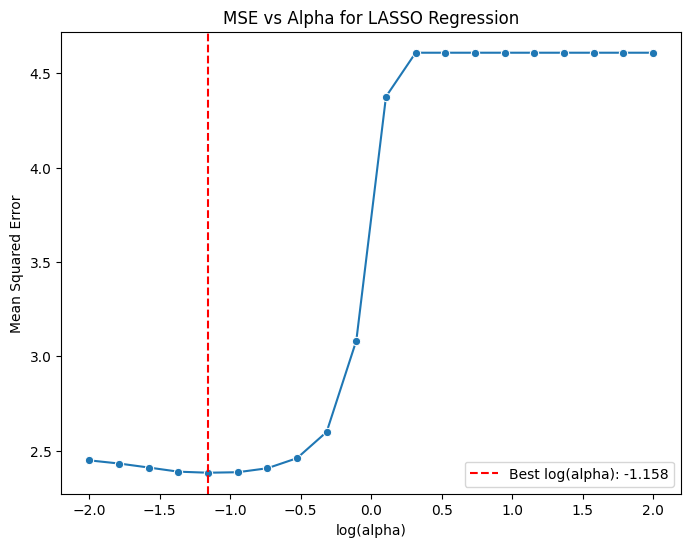

In [70]:
# get alphas and MSE scores from LASSO grid search results
alphas = lasso_cv.cv_results_['param_regressor__alpha'].data.astype(float)
mse_scores = -lasso_cv.cv_results_['mean_test_score']  # negative because we used neg_mean_squared_error
best_alpha = lasso_cv.best_params_['regressor__alpha']

# create plot
plt.figure(figsize=(8, 6))
sns.lineplot(x=np.log10(alphas), y=mse_scores, marker = 'o', errorbar=None)
plt.axvline(x=np.log10(best_alpha), color='r', linestyle='--', label=f'Best log(alpha): {np.log10(best_alpha):.3f}')
plt.xlabel('log(alpha)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha for LASSO Regression')
plt.legend()
plt.show()

Now, let's begin the analysis and model evaluation. First, here are the coeffficient values for both models.

In [71]:
# get best models / pipelines
best_model_ols = ols_pipeline.named_steps['regressor']
best_pipeline_ols = ols_pipeline
best_model_lasso = lasso_cv.best_estimator_.named_steps['regressor']
best_pipeline_lasso = lasso_cv.best_estimator_

# get coefficients from best models
ols_intercept = best_model_ols.intercept_
ols_coef = best_model_ols.coef_
ols_coef_full = np.concatenate(([ols_intercept], ols_coef))

lasso_intercept = best_model_lasso.intercept_
lasso_coef = best_model_lasso.coef_
lasso_coef_full = np.concatenate(([lasso_intercept], lasso_coef))

# create results dataframes
ols_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': ols_coef_full
})

lasso_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(predictors),
    'Coefficient': lasso_coef_full
})

# rename features
feature_map = {
    'Intercept': "Intercept",
    'work_ethic': 'Work Ethic',
    'trust': 'Trust',
    'equality': 'Equality',
    'religion': 'Religion',
    'log_gdp_per_capita': 'Log GDP Per Capita',
    'hdi': 'Human Development Index',
}

ols_results['Feature'] = ols_results['Feature'].map(feature_map)
lasso_results['Feature'] = lasso_results['Feature'].map(feature_map)

ols_results_sorted = ols_results.sort_values(by='Coefficient', key=abs, ascending=False)
lasso_results_sorted = lasso_results.sort_values(by='Coefficient', key=abs, ascending=False)

print("OLS Coefficients")
display(ols_results_sorted)

print("LASSO Coefficients")
display(lasso_results_sorted)

OLS Coefficients


,Feature,Coefficient
0,Intercept,-3.960031
6,Human Development Index,2.027983
3,Equality,1.916427
1,Work Ethic,-0.465768
2,Trust,0.441535
5,Log GDP Per Capita,0.341164
4,Religion,-0.025137


LASSO Coefficients


,Feature,Coefficient
0,Intercept,5.853801
3,Equality,0.822738
5,Log GDP Per Capita,0.477436
6,Human Development Index,0.253951
2,Trust,0.169615
1,Work Ethic,-0.112609
4,Religion,-0.006897


For more clarity and interpretability, we graph our coefficients to show their magnitudes:

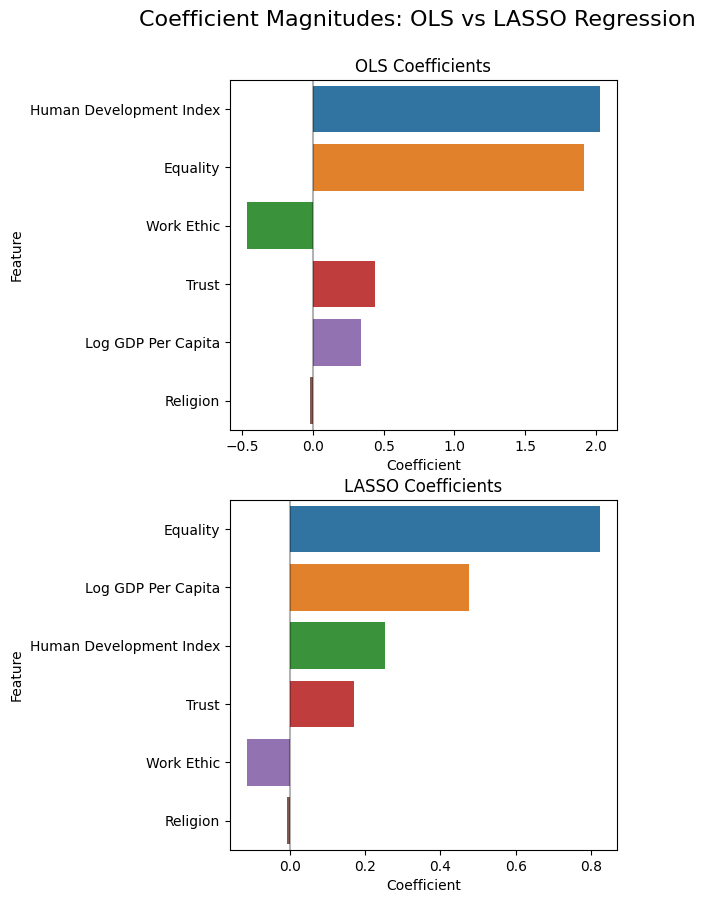

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.suptitle('Coefficient Magnitudes: OLS vs LASSO Regression', fontsize=16, y=0.95)

axes = axes.flatten()

# create OLS plot
sns.barplot(data=ols_results_sorted[1:], y='Feature', x='Coefficient', ax=axes[0], orient='h')
axes[0].set_title(f'OLS Coefficients')
axes[0].axvline(0, color='black', alpha=0.3)

sns.barplot(data=lasso_results_sorted[1:11], y='Feature', x='Coefficient', ax=axes[1], orient='h')
axes[1].set_title(f'LASSO Coefficients')
axes[1].axvline(0, color='black', alpha=0.3)

From comparing the OLS and LASSO coefficients, we can see some interesting patterns. In the OLS model, the Human Development Index and equality show strong positive relationships with democracy scores, followed by smaller positive effects from trust and log GDP per capita, while work ethic shows a negative relationship. Since our moral values are on the same scale, we can thus see that equality appears to have the strongest relationship with the democracy index. 

When we look at the LASSO results, which reduce less important features and uses the standardized versions of our predictors, equality emerges as clearly the strongest predictor, followed by log GDP per capita, while HDI's importance is notably reduced. This can start to suggest that equality and economic development (measured by GDP per capita) are the strongest/most fundamental associates of democracy. Obviously, there is more work to be done to make this full conclusion, but off of our first pass, these results appear to support the above conclusions.

Now, let's calculate the standard errors for the OLS model. This will help us understand whether we believe our coefficients are significantly different from zero given our normality assumption on the data. We do not calculate standard errors for the LASSO model since there is no consensus on a statistically valid way to calculate standard errors for LASSO in the literature. Any statistically valid method here requires stringent assumptions and a very large dataset (Zhao et. al, 2021). This is because of the lack of an analytical solution for standard errors due to our regularization term. Regardless, the feature selection that was done by our LASSO model is useful in helping us understand the most important predictors of a democratic nation. Now, we will compute both the analytic confidence intervals for the OLS model and the bootstrapped confidence intervals. We use both for the following reasons:

The analytic confidence intervals are typically used in statistical analyses and are based in statistical theory. However, they require the assumptions of normality of residuals (errors) and homoskedasticity of residuals apply. In the case that these assumptions are not met, the bootstrap confidence interval provides us a more robust interval of estimates and can also capture non-linearities and asymmetries in the sampling distribution of estimates.

Citation: Sen Zhao. Daniela Witten. Ali Shojaie. "In Defense of the Indefensible: A Very Naïve Approach to High-Dimensional Inference." Statist. Sci. 36 (4) 562 - 577, November 2021. https://doi.org/10.1214/20-STS815

In [73]:
"""
Get R-squared value of OLS model
"""

y_pred =  best_pipeline_ols.predict(X)

r2 = r2_score(y, y_pred)

print(f"R-squared value of OLS model: {r2:.3f}")

R-squared value of OLS model: 0.570


Our R-squared value tells us that about 57% of the variation in our democracy scores across countries is explained by our OLS regression model. This is a pretty high value which tells us that the development and values of a country appear to explain much of the variation in democracy scores across countries.

In [74]:
"""
Get analytic confidence intervals
"""
n, p = X.shape
residuals = y - y_pred

# estimate variance of the error term
s2 = np.sum(residuals ** 2) / (n - p - 1)

# calculate standard errors
X_design_ols = np.hstack([np.ones((n, 1)), X])  # add intercept
se = np.sqrt(s2 * np.diag(np.linalg.inv(X_design_ols.T @ X_design_ols)))

# calculate confidence intervals
z_crit = 1.96
ci_lower_analytic = ols_coef_full - z_crit * se
ci_upper_analytic = ols_coef_full + z_crit * se

# add to OLS results dataframe
ols_results['SE'] = se
ols_results['CI_Lower_Analytic'] = ci_lower_analytic
ols_results['CI_Upper_Analytic'] = ci_upper_analytic


In [75]:
def bootstrap(X, y, pipeline, n_bootstraps=1000):
    """
    Performs bootstrap resampling and returns coefficient estimates for each bootstrap sample.
    - returns an array of shape (n_bootstraps, n_features + 1) containing coefficient estimates for each bootstrap sample, including intercept
    """
    bootstrap_coefs = []
    
    for i in range(n_bootstraps):
        # generate bootstrap sample
        X_bootstrap, y_bootstrap = resample(X, y, random_state=i)
        
        # fit pipeline on bootstrap sample
        pipeline_boot = clone(pipeline)
        pipeline_boot.fit(X_bootstrap, y_bootstrap)
                
        # get coefficients. includes intercept.
        coef_boot = np.concatenate([[pipeline_boot.named_steps['regressor'].intercept_], pipeline_boot.named_steps['regressor'].coef_])
        
        bootstrap_coefs.append(coef_boot)
    
    return np.array(bootstrap_coefs)

In [76]:
"""
Get bootstrap confidence intervals
"""
# get bootstrapped coefficients
ols_coef_bootstrap = bootstrap(X, y, best_pipeline_ols)
bootstrap_distributions = [ols_coef_bootstrap[:, i] for i in range(ols_coef_bootstrap.shape[1])]

# calculate standard errors
se_boot = np.std(ols_coef_bootstrap, axis=0)

# calculate bootstrapped confidence intervals
ci_lower_boot = ols_coef_full - z_crit * se_boot
ci_upper_boot = ols_coef_full + z_crit * se_boot

# add to OLS results dataframe
ols_results['SE_Boot'] = se_boot
ols_results['CI_Lower_Boot'] = ci_lower_boot
ols_results['CI_Upper_Boot'] = ci_upper_boot
ols_results['Bootstrap'] = bootstrap_distributions

display(ols_results)

,Feature,Coefficient,SE,CI_Lower_Analytic,CI_Upper_Analytic,SE_Boot,CI_Lower_Boot,CI_Upper_Boot,Bootstrap
0,Intercept,-3.960031,1.585584,-7.067776,-0.852287,2.017434,-7.914202,-0.005861,"[-3.352714048944571, -2.635444514811061, -2.68..."
1,Work Ethic,-0.465768,0.285245,-1.024847,0.093312,0.298081,-1.050006,0.118471,"[-1.0210574414666416, -0.5614620032747137, -0...."
2,Trust,0.441535,0.238651,-0.026221,0.909291,0.201226,0.047131,0.835938,"[0.41596378814675783, 0.17779185749175053, 0.3..."
3,Equality,1.916427,0.252937,1.420669,2.412184,0.226834,1.471832,2.361021,"[2.3672782813988604, 1.9068884946677536, 2.207..."
4,Religion,-0.025137,0.159568,-0.337890,0.287615,0.208712,-0.434212,0.383938,"[0.2342365815685948, -0.32235328792830736, 0.0..."
5,Log GDP Per Capita,0.341164,0.166447,0.014928,0.667400,0.221273,-0.092531,0.774859,"[-0.12157196850635851, 0.676446452003656, -0.0..."
6,Human Development Index,2.027983,1.694424,-1.293088,5.349055,1.908544,-1.712762,5.768729,"[5.645441748820155, -1.519845776519716, 4.7291..."


Here are visualizations of the distributions for the bootstrapped LASSO coefficients with the bootstrapped and analytic confidence intervals overlayed on top of them.

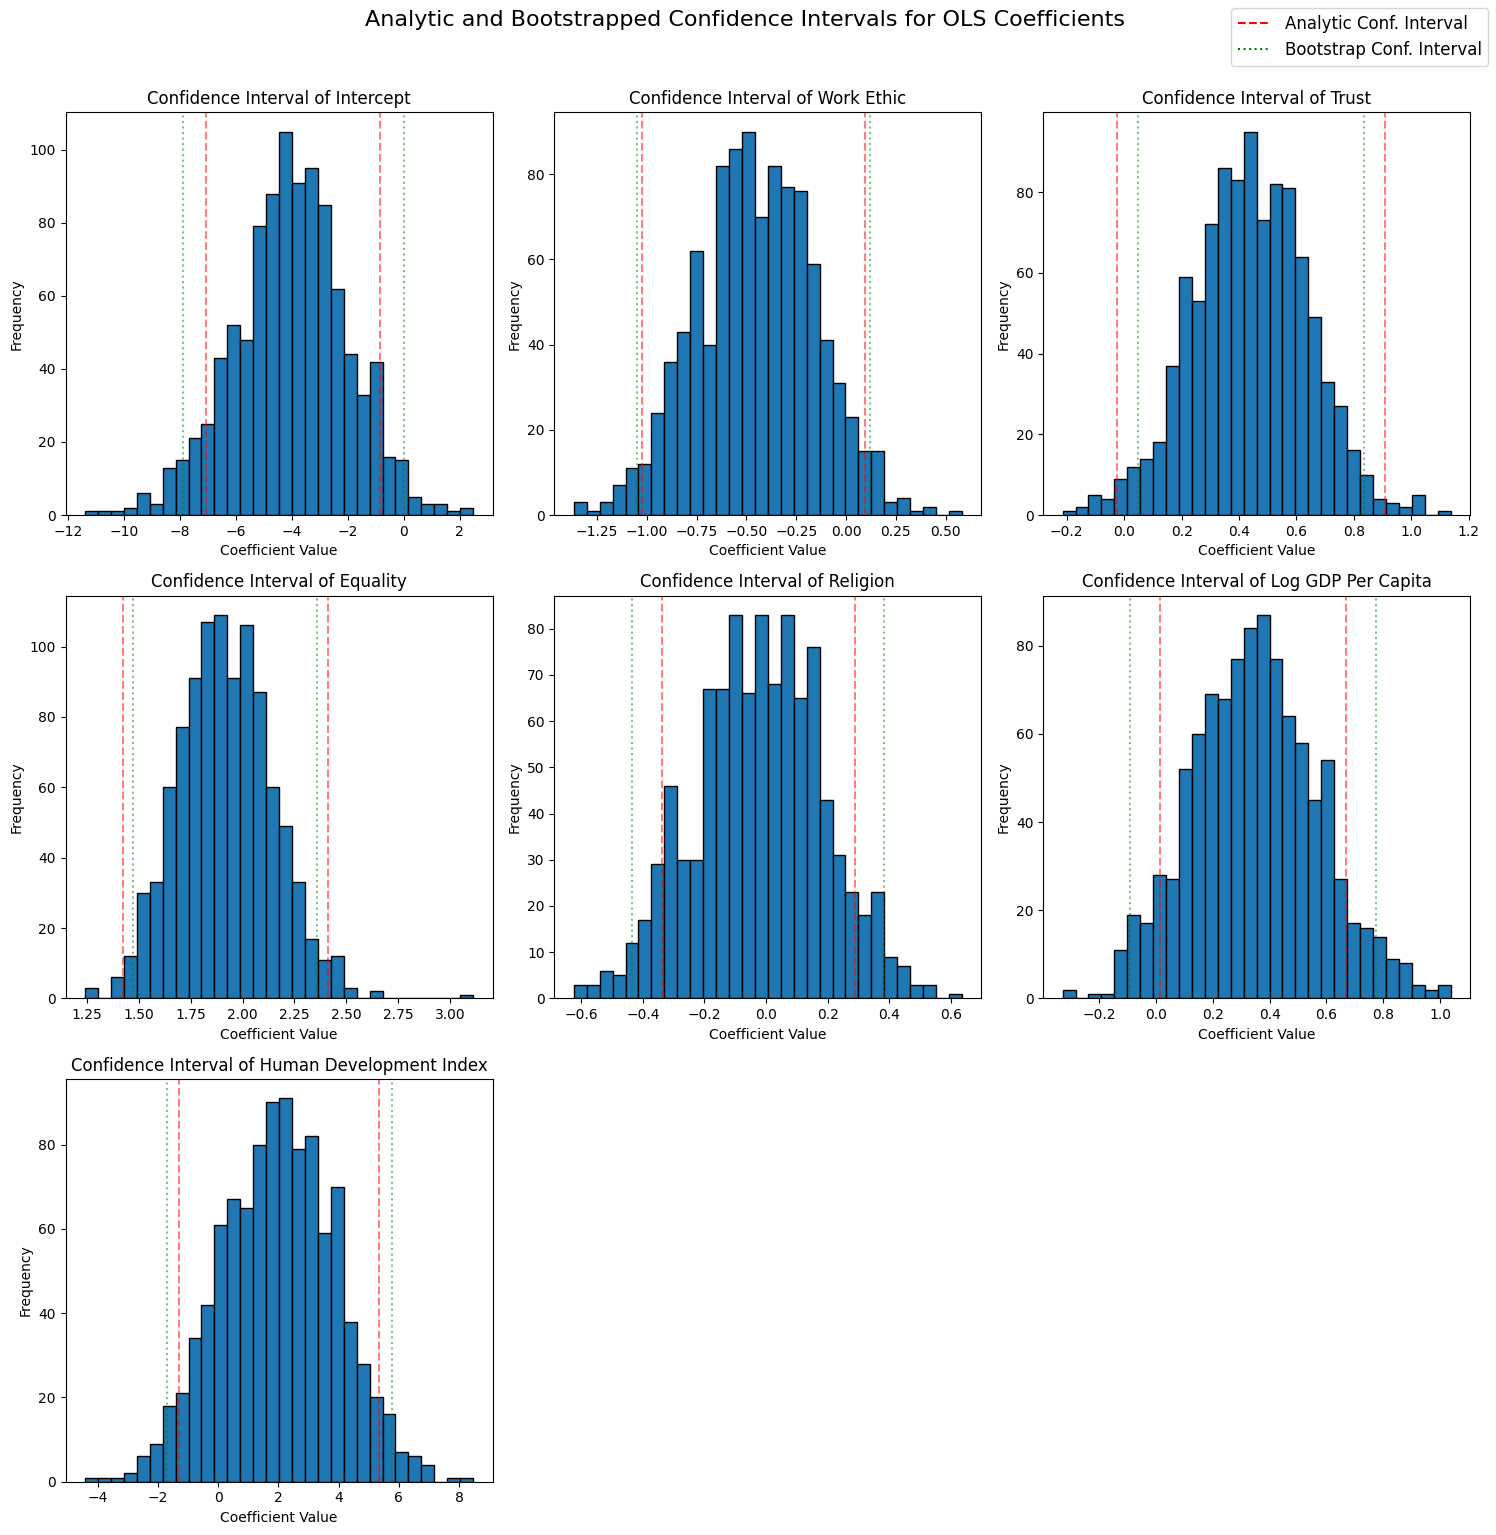

In [77]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Analytic and Bootstrapped Confidence Intervals for OLS Coefficients', fontsize=16, y=1.02)
axes = axes.flatten()

# create legend
legend_elements = [
    plt.Line2D([0], [0], color='r', linestyle='--', label='Analytic Conf. Interval'),
    plt.Line2D([0], [0], color='g', linestyle=':', label='Bootstrap Conf. Interval')
]

# plot histograms for each feature
for i, (idx, row) in enumerate(ols_results.iterrows()):
    feature = row['Feature']
    ci_lower_analytic = row['CI_Lower_Analytic']
    ci_upper_analytic = row['CI_Upper_Analytic']
    ci_lower_boot = row['CI_Lower_Boot']
    ci_upper_boot = row['CI_Upper_Boot']
    coef_dist = row["Bootstrap"]  
      
    # Create histogram
    axes[i].hist(coef_dist, bins=30, edgecolor='black')
    
    # Add vertical lines for confidence intervals
    axes[i].axvline(x=ci_lower_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_upper_analytic, color='r', linestyle='--', alpha=0.5)
    axes[i].axvline(x=ci_lower_boot, color='g', linestyle=':', alpha=0.5)
    axes[i].axvline(x=ci_upper_boot, color='g', linestyle=':', alpha=0.5)
    
    # Add title and labels
    axes[i].set_title(f'Confidence Interval of {feature}')
    axes[i].set_xlabel('Coefficient Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(lasso_results), len(axes)):
    axes[i].set_visible(False)

fig.legend(handles=legend_elements, loc='upper right', fontsize = 12)

plt.tight_layout()
plt.show()

Using the OLS model, we can now do proper inference to see which of the features are statistically significant. Based on both the bootstrapped and analytic confidence intervals, the "equality" metric is the only significant predictor of democracy, though log GDP per capita and Trust are both nearly significant. This is consistent with the analysis from the LASSO regression above, which selected equality as the strongest predictor. Intuitively, it makes sense that few metrics would be significant. That is because many of these indices are correlated, and so by including them all in a single regression, it dilutes the effect of each one by eliminating confounders and minimizing omitted variable bias. Also, it makes sense that equality is the strongest predictor of democracy: democracies are built upon equality!

Now, we will use statistical inference to check whether equality actually exhibits a quadratic relationship with democracy score. To do this, we will include an equality squared term in the OLS regression, and see whether it's statistically significant at the five percent level.

The idea is that we want to pin down the precise relationship between equality and democracy. We have already established that as equality increases, democracy increases too, but we want to figure out whether that relationship is linear or not. I.e. does the effect get stronger or weaker at different values of the independent variable. To do this, we see whether the quadratic term is signficiant. A non-significant squared term suggests that the relationship is linear.

In [78]:

predictors_v2 = predictors + ['equality_squared']
X_v2 = df[predictors_v2]
ols_pipeline = Pipeline([
    ('regressor', LinearRegression())
])
ols_cv = cross_validate(
    ols_pipeline,
    X_v2, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)
ols_pipeline.fit(X_v2, y)
coef_dict = dict(zip(predictors_v2, ols_pipeline.named_steps['regressor'].coef_))
for pred, coef in coef_dict.items():
    print(f"{pred}: {coef:.3f}")
X_with_const = sm.add_constant(X_v2)
model_eq_squared = sm.OLS(y, X_with_const)
results_eq_squared = model_eq_squared.fit()
print("\nEquality squared p-value:", results_eq_squared.pvalues['equality_squared'])

work_ethic: -0.359
trust: 0.309
equality: -0.313
religion: -0.032
log_gdp_per_capita: 0.325
hdi: 2.159
equality_squared: 0.403

Equality squared p-value: 0.21537380592086228


Note that the equality_squared coefficient is not stastistically significant. (4.03 minus 1.96 * 0.215 is less than zero --- barely!) This means that there is no statistically significant non-linear relationship between any of the variables and democracy score.

Next, we will see if equality is still significant when we include wave fixed effects. This idea comes directly from our discussion of fixed effects in milestone 3 and our above EDA. As discussed above, even though adding country fixed effects would be ideal (so we can also control for time-invariant country specific characteristics), our dataset does not have enough time-series data for countries to implement these fixed effects without overfitting (we had a 0.99 R-squared value when we tested the use of country fixed effects).

In [99]:

# get dummies for our waves to use for fixed effects and plug that into our X matrix
wave_dummies = pd.get_dummies(df['wave'], prefix='wave', drop_first=True, dtype=int)
X_full = pd.concat([
    X,
    wave_dummies
], axis=1)

# set up OLS FE pipeline and get cross-validation 
ols_fe_pipeline = Pipeline(steps=[
   ('regressor', LinearRegression())
])
ols_fe_cv = cross_validate(
    ols_fe_pipeline,
    X_full, y,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# get mean validation mse and std dev of mses
ols_fe_pipeline.fit(X_full, y)

best_model_fe = ols_fe_pipeline.named_steps['regressor']

# get our coefficients and turn into a dataframe for interpretations
best_pipeline_fe = ols_fe_pipeline
fe_coef_full = np.concatenate(([best_model_fe.intercept_], best_model_fe.coef_))
fe_results = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_full.columns), 
    'Coefficient': fe_coef_full
})

# get residuals in order to get confidence intervals 
y_pred_fe = best_pipeline_fe.predict(X_full)
n_fe, p_fe = X_full.shape
residuals_fe = y - y_pred_fe

# calculate confidence intervals for our fixed effects model
s2_fe = np.sum(residuals_fe ** 2) / (n_fe - p_fe - 1)
X_design_fe = np.hstack([np.ones((n_fe, 1)), X_full])
se_fe = np.sqrt(s2_fe * np.diag(np.linalg.inv(X_design_fe.T @ X_design_fe)))
z_crit = 1.96 
ci_lower_fe = fe_coef_full - z_crit * se_fe
ci_upper_fe = fe_coef_full + z_crit * se_fe
fe_results['SE'] = se_fe
fe_results['CI_Lower'] = ci_lower_fe  
fe_results['CI_Upper'] = ci_upper_fe 

display(fe_results)

,Feature,Coefficient,SE,CI_Lower,CI_Upper
0,Intercept,-1.879989,1.535728,-4.890016,1.130039
1,work_ethic,-0.511586,0.268953,-1.038733,0.015561
2,trust,0.030109,0.234489,-0.429488,0.489707
3,equality,1.800640,0.241520,1.327262,2.274019
4,religion,-0.126755,0.151260,-0.423224,0.169714
5,log_gdp_per_capita,0.363030,0.159136,0.051124,0.674936
6,hdi,2.144428,1.614542,-1.020073,5.308930
7,wave_2.0,-1.095291,0.212766,-1.512312,-0.678270
8,wave_3.0,-1.062671,0.200500,-1.455651,-0.669691


In [91]:
# get r-squared value of our fixed effects model
r2_fe = r2_score(y, y_pred_fe)

print(f"R-squared value of Fixed Effects model: {r2_fe:.3f}")

R-squared value of Fixed Effects model: 0.623


Interestingly, not only does equality remain significant, but log gdp per capita becomes significant as well! In addition, work ethic becomes extremely close to being significant while trust no longer is close to significant. When we include wave fixed effects, we're essentially looking at how changes in these variables relate to changes in democracy scores by country, while controlling for any global trends that affect all countries in a given wave since we include wave dummies in our regression. This is different from our previous analysis that looked at differences between countries without controlling for the time period. This regression could indicate that once the confounding effects of time-specific variables are removed, the relationship between economic development and democracy (and also work ethic almost) become significant. As such, it could be valuable to include these dummies for use in our final model to continue controlling for these potential time-based confounders.

Also, it is worth mentioning that both of our wave dummies are significant at the 5% level and have negative coefficients. This actually indicates that being in wave 2 or wave 3 (compared to being in wave 1 and holding all other values constant) is associated with a lower democracy score. This could suggest that countries are actually just in general becoming less democratic over time in a way unrelated to their values!

We will now check whether our OLS regression assuptions are satisfied (which will help us make a decision on whether we think our analytical CIs are valid). First, we will see whether the residuals are approximately normally distributed. We will do this analysis for both our original regression and our fixed effects regression.

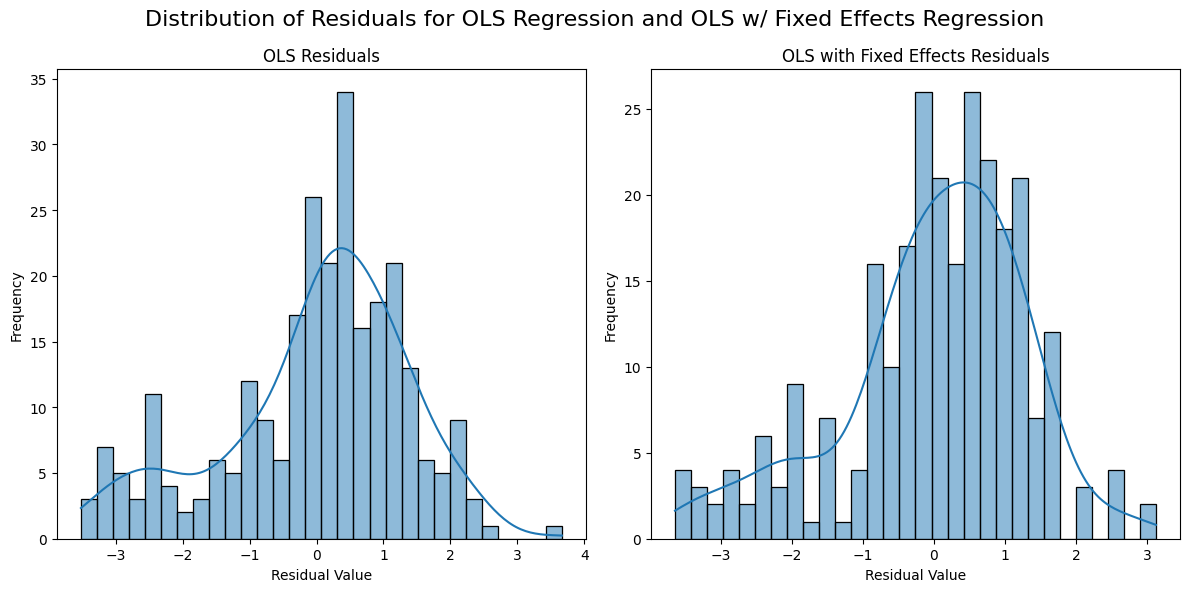

In [ ]:
# create 1 x 2 grid for our histogram of residuals: one for OLS and one for fixed effects

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Distribution of Residuals for OLS Regression and OLS w/ Fixed Effects Regression', fontsize=16)


sns.histplot(residuals, bins=30, ax=axes[0], kde=True)
axes[0].set_title('OLS Residuals')
axes[0].set_xlabel('Residual Value')
axes[0].set_ylabel('Frequency')

sns.histplot(residuals_fe, bins=30, ax=axes[1], kde=True)
axes[1].set_title('OLS with Fixed Effects Residuals')
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

Next, we will check to see whether the residuals are homoskedastic and linear.

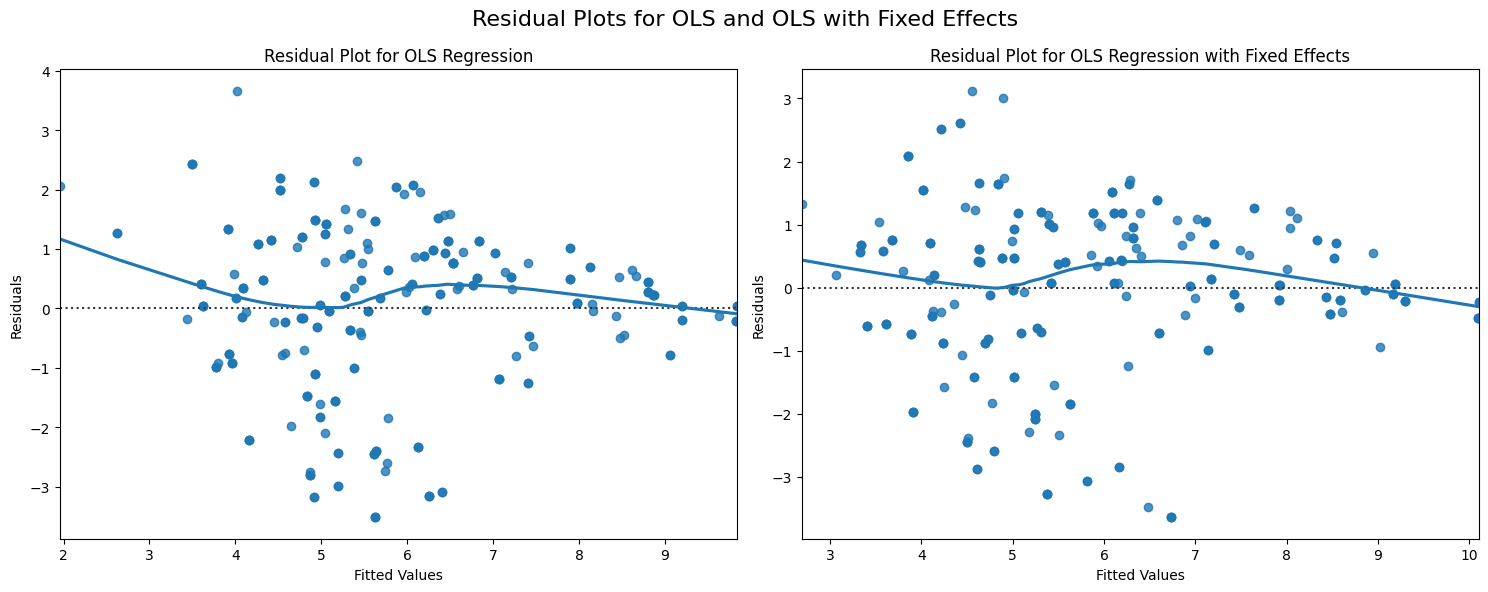

In [ ]:
# create 1 x 2 grid for residual plots: one for OLS and one for OLS with fixed effects

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Residual vs. Fitted Plots for OLS and OLS with Fixed Effects', fontsize=16)

# create residual plot for OLS
sns.residplot(x=y_pred, y=residuals, lowess=True, ax=axes[0])
axes[0].set_title('Residual Plot for OLS Regression')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# create residual plot for OLS with fixed effects
sns.residplot(x=y_pred_fe, y=residuals_fe, lowess=True, ax=axes[1])
axes[1].set_title('Residual Plot for OLS Regression with Fixed Effects')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

plt.tight_layout()

The graphs above have quite similar results between our normal OLS and OLS with fixed effects models. As we can see from these two graphs above, normality and homoskedasticity of residuals appear to be violated. The violation of normality is less consequential given our larger sample size and the central limit theorem. Homoskedasticity appears to be significantly violated which does affect our calculation of our analytical standard errors which could lead to inaccurate tests and inference. Our bootstrapped CIs are more robust to this violation, however. Although the residual plot above may appear slightly nonlinear, our analysis above illustrates that there is no significant breaching of nonlinearity. In addition, with high $n$, the violation of homoskedasticity is less consequential on our inference. As we saw in our heatmaps from our EDA, there could be some minor issues with multicollinearity as some predictors have moderately large correlation coefficients with each other (|r| > 0.5). This can be a potential issue as it means our coefficient predictions are less stable and our inference is less reliable. Linearity, from our residuals vs. fitted plots, appears to be generally reasonably followed. There may be a small violation, but this is not really significant (which we also tested for outside of this notebook).

With all of this being said, we believe that our multiple OLS regression is a great baseline model, but we still feel that it would be valuable to do more modeling to make sure that our results are truly robust to these issues of multicollinearity and homoskedasticity. As such, we want to use a random forest regression model as our final model for variable selection. Even though we did not find any significant nonlinearities in our errors, the random forest is still robust to any of these issues of nonlinearity. This is because the splits of a decision tree create piecewise boundaries on there own. In addition, variable importance from permutation tests of a random forest model do not depend at all on any normality or homoskedasticity assumptions. 

Decision trees are also more robust to multicollinearity. Indeed, Genuer et. al (2010), a peer-reviewed paper cited over 3000 times, shows that when engaging in variable selection for interpretation purposes, the addition of highly-correlated variables to already-known important vriables only affected the magnitude -- NOT the order -- of variable importance for the random forest permutation importance statistics. They also show that the optimal way to engage in variable selection for interpretation purposes aligned with our method chosen in our proposal: Construct RF models with different hyperparameter values and choose the RF model with the lowest OOB error rate for interpretation and feature selection. 

There are, however, tradeoffs when using the RF model over the multiple OLS linear regression. The RF model is less interpretable than a linear regression and pretty much only useful for feature selection given that our project is not concerned with prediction. The use of LIME importance may help increase interpretability, but the point stands that linear regression is very easily interpreted. We also are unable to engage in any meaningful inference using this model either. Thus, although the RF model is seen as our ``final model'' for the reasons detailed above, it is not our only model and we will still consider the multiple OLS regression in our discussion of the results.

Citation: Robin Genuer, Jean-Michel Poggi, Christine Tuleau-Malot. Variable selection using Random Forests. Pattern Recognition Letters, Elsevier, 2010, 31 (14), pp.2225-2236.



### Random Forest Regression Pipeline

Given our discussion above, we will now build a pipeline for our random forest regression model. 

A few things about how we set up preprocessing for pipeline:

- We do not need to engage in any feature preprocessing again. We do not need to standardize our variables because decision trees use _thresholds_ rather than _levels_, which means that different scales do not affect our overall fit or our ultimate feature importance values. We will also, based on our results from our baseline model exploration, try adding our wave dummy variables into our analysis given their significance in our model.
- We do not need any specific polynomial or log transformation as decision trees can inherently capture non-linear relationships in the data because its splits create piecewise decision boundaries on its own.

The model selection process will be as follows:

- The hyperparameters that we need to tune are: 
    - We will use MSE as our splitting criteria. This is the main criteria used by most practioners and the only one we learned in class. 
    - Max_features: Sqrt or log2. Sqrt is the method that most long time practicioners use for random forests and log2 is another popular method so we will try both.
    - Number of trees: (1 to 250 with stepsize of 25): We need to figure out how many trees should be fit. Given that our dataset is not huge, we expect a fairly low number of trees need to be fit to best generalize to our data and after that there are diminishing returns. 
    - Complexity: We will tune max_depth, max_leaf_nodes, and min_impurity_decrease (also known as accuracy gain) as our separate measures for limiting complexity. Max_depth and max_leaf_nodes are both classic methods of controlling complexity and differ in how balanced the tree becomes while min_impurity_decrease is a frequently used method for controlling complexity in decision tree regression cases.
        - For now, we will iterate through max depth values between 1 and 25 with stepsize of 2, max leaf nodes values between 1 and 100 with stepsize of 5, and impurity decrease thresholds between 0 and 0.5 (0, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5). These are subject to change as we work with the model and see results but are good starting points for testing complexity.
        - We will use only one of these complexity methods at a time rather than use multiple of these complexity reduction methods at once as this would be far too computationally complex and likely not that useful for our purposes of interpreting feature importance.
    
- To choose our hyperparameters, we will use out-of-bag error. We use this over cross validation since with cross validation there is a leakage of data (every validation has been seen in training by a few decision trees and there is thus some form of leakage). OOB prevents leakage and has a lower computation cost. 

Once we have chosen the best hyperparameters for our model, we can then engage in feature importance analysis. We can begin by looking at permutation importance which is more robust than built-in MDI importance as discussed in class (MDI usually focuses too much on variables with high cardinality or numerical variables). 

We also will experiment with LIME as a way to measure feature importance because it:
- Provide us with local explanations. In other words, it explains individual predictions by estimating the importance of each feature for a specific data point.
- It allows for greater interpretability -- we can look at why our model gave specific predictions. 
- Having both a global and a local variable importance measure will give us more information regarding the associations between countries' various beliefs and how democratic they are.

Below is a pipeline that we have created to tune our random forest model using OOB error. To run this pipeline, we would simply build our param grid (using the values we stated earlier), and plug in our data.

In [ ]:
"""Function for tuning random forest model using OOB error"""

def tune_random_forest(X, y, params_grid, random_state, preprocessor=None):
    """
    Tune a Random Forest model using OOB error.
    - X: features data
    - y: response variable data
    - params_grid: dictionary of hyperparameters to search over
    - random_state: random seed
    - preprocessor: preprocessor to use in pipeline
    """

    best_params = None
    best_oob_score = 0
    results = []

    # iterate through all possible hyperparameter combos 
    for param in ParameterGrid(params_grid):
        # set up pipeline
        if preprocessor:
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', RandomForestRegressor(random_state=random_state, oob_score=True, **param))
            ])
        else:
            pipeline = Pipeline(steps=[
                ('classifier', RandomForestRegressor(random_state=random_state, oob_score=True, **param))
            ])

        # fit model
        pipeline.fit(X, y)

        # get OOB score
        oob_score = pipeline.named_steps['classifier'].oob_score_

        # save results
        results.append({
            'params': param,
            'oob_score': oob_score
        })

        # update best parameters
        if oob_score > best_oob_score:
            best_oob_score = oob_score
            best_params = param
            
    return {'best_params': best_params, 'best_oob_score': best_oob_score, 'results': results}


## Appendix

### WVS Question Categories

- Work Ethic
    - A005: Important in life: Work
    - E040: Hard work brings success
    - A030: Important child qualities: Hard work
    - A104:	Active/inactive membership of professional organization

- Trust
    - A165	Most people can be trusted
    - G007_18_B	Trust: Your neighborhood (B)
    - G007_33_B	Trust: People you know personally (B)
    - G007_34_B	Trust: People you meet for the first time (B)
    - G007_35_B	Trust: People of another religion (B)
    - G007_36_B	Trust: People of another nationality (B)

- Equality
    - Gender
        - D078	Men make better business executives than women do
        - D059	Men make better political leaders than women do
        - C001	Jobs scarce: Men should have more right to a job than women (3 categories)
        - E233	Democracy: Women have the same rights as men.
        - F199	Justifiable: For a man to beat his wife
    - General Tolerance
        - A124_02 Neighbours: People of a different race
        - A124_06	Neighbours: Immigrants/foreign workers
        - A105	Active/Inactive membership of charitable/humanitarian organization
        - E124	Respect for individual human rights nowadays
        - E069_40	Confidence: Charitable or humanitarian organizations
        - C002	Jobs scarce: Employers should give priority to (nation) people than immigrants (3 categories)

- Religion
    - Involvement
        - A040: Important child qualities: religious faith
        - A098: Active/Inactive membership of church or religious organization
        - E069_01	Confidence: Churches
        - F028	How often do you attend religious services
        - F028B	How often to you pray
        - F034	Religious person
        - F050	Believe in: God
        - F063	How important is God in your life
    - Extremism
        - F203	The only acceptable religion is my religion
        - F202	Whenever science and religion conflict, religion is always right
        - E220	We depend too much on science and not enough on faith